In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mostafaabla/garbage-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/garbage-classification


In [2]:
!cp -r /kaggle/input/garbage-classification /content/


In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


In [4]:
# Path to the main dataset folder containing class subfolders
DATASET_PATH = "/content/garbage-classification/garbage_classification"

# Define recyclable and non-recyclable classes
recyclable_classes = [
    'paper', 'cardboard', 'metal', 'plastic',
    'green-glass', 'brown-glass', 'white-glass'
]

non_recyclable_classes = [
    'biological', 'clothes', 'shoes', 'batteries', 'trash'
]

# Map each class to a binary label
class_to_label = {}
for c in recyclable_classes:
    class_to_label[c] = 1  # Recyclable = 1
for c in non_recyclable_classes:
    class_to_label[c] = 0  # Non-Recyclable = 0


In [5]:
image_paths = []
labels = []

for class_name in os.listdir(DATASET_PATH):
    class_folder = os.path.join(DATASET_PATH, class_name)
    if os.path.isdir(class_folder) and class_name in class_to_label:
        for img_file in os.listdir(class_folder):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(class_folder, img_file))
                labels.append(class_to_label[class_name])

print(f"Total images found: {len(image_paths)}")


Total images found: 14570


In [6]:
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)


In [7]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Validation data generator without augmentation
val_datagen = ImageDataGenerator(rescale=1./255)


In [8]:
def path_label_generator(paths, labels, datagen):
    while True:
        for start in range(0, len(paths), BATCH_SIZE):
            end = min(start + BATCH_SIZE, len(paths))
            batch_paths = paths[start:end]
            batch_labels = labels[start:end]

            batch_images = []
            for img_path in batch_paths:
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                batch_images.append(img_array)

            batch_images = np.array(batch_images)
            batch_labels = np.array(batch_labels)

            # Create iterator from datagen.flow
            batch_iter = datagen.flow(batch_images, batch_labels, batch_size=BATCH_SIZE, shuffle=True)
            yield next(batch_iter)   # Use Python's built-in next()


In [9]:
train_generator = path_label_generator(train_paths, train_labels, train_datagen)
val_generator = path_label_generator(val_paths, val_labels, val_datagen)


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary output
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Calculate steps per epoch
train_steps = len(train_paths) // BATCH_SIZE
val_steps = len(val_paths) // BATCH_SIZE

history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=15,
    validation_data=val_generator,
    validation_steps=val_steps
)


Epoch 1/15
364/364 ━━━━━━━━━━━━━━━━━━━━ 65s 163ms/step - accuracy: 0.6677 - loss: 0.6096 - val_accuracy: 0.7531 - val_loss: 0.4858
Epoch 2/15
364/364 ━━━━━━━━━━━━━━━━━━━━ 60s 160ms/step - accuracy: 0.7394 - loss: 0.5030 - val_accuracy: 0.8046 - val_loss: 0.4133
Epoch 3/15
364/364 ━━━━━━━━━━━━━━━━━━━━ 81s 223ms/step - accuracy: 0.7770 - loss: 0.4587 - val_accuracy: 0.8214 - val_loss: 0.3800
Epoch 4/15
364/364 ━━━━━━━━━━━━━━━━━━━━ 59s 163ms/step - accuracy: 0.7901 - loss: 0.4331 - val_accuracy: 0.8279 - val_loss: 0.3544
Epoch 5/15
364/364 ━━━━━━━━━━━━━━━━━━━━ 80s 221ms/step - accuracy: 0.8053 - loss: 0.4126 - val_accuracy: 0.8317 - val_loss: 0.3508
Epoch 6/15
364/364 ━━━━━━━━━━━━━━━━━━━━ 82s 226ms/step - accuracy: 0.8127 - loss: 0.3939 - val_accuracy: 0.8529 - val_loss: 0.3188
Epoch 7/15
364/364 ━━━━━━━━━━━━━━━━━━━━ 82s 226ms/step - accuracy: 0.8294 - loss: 0.3671 - val_accuracy: 0.8602 - val_loss: 0.3046
Epoch 8/15
364/364 ━━━━━━━━━━━━━━━━━━━━ 41s 114ms/step - accuracy: 0.8283 - loss: 0

In [12]:
# Save the model in TensorFlow's SavedModel format
model.save('garbage_classifier_model.h5')

print("Model saved successfully!")


Model saved successfully!


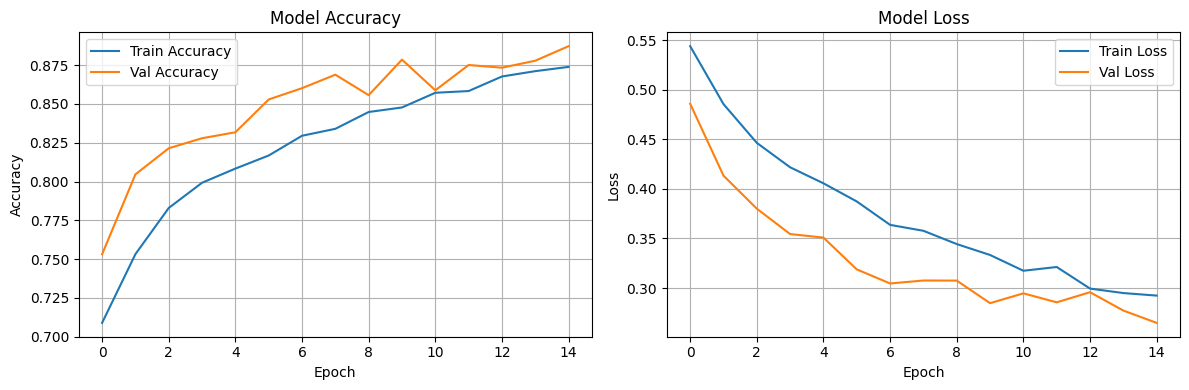

✅ Saved: plots/accuracy_loss_curves.png
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

📋 Classification Report:
                precision    recall  f1-score   support

Non-Recyclable       0.92      0.89      0.91      1797
    Recyclable       0.83      0.88      0.86      1117

      accuracy                           0.89      2914
     macro avg       0.88      0.88      0.88      2914
  weighted avg       0.89      0.89      0.89      2914



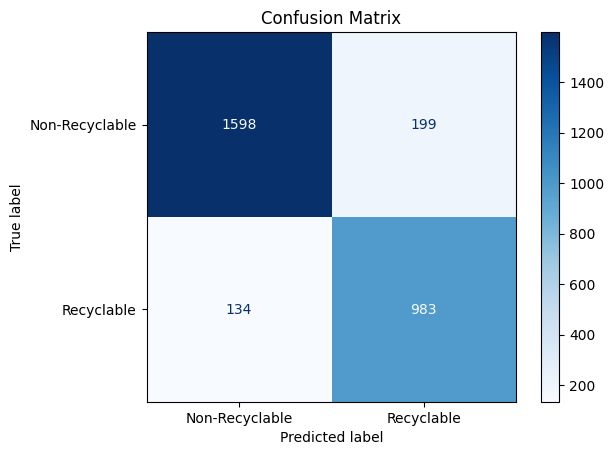

✅ Saved: plots/confusion_matrix.png


In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import os

# Create a folder for saving plots
os.makedirs("plots", exist_ok=True)

# ----- 1. Accuracy and Loss Curves -----
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("plots/accuracy_loss_curves.png")
plt.show()
print("✅ Saved: plots/accuracy_loss_curves.png")

# ----- 2. Predictions on Validation Set -----
val_images = []
true_labels = []

for img_path, label in zip(val_paths, val_labels):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    val_images.append(img_array)
    true_labels.append(label)

val_images = np.array(val_images)
true_labels = np.array(true_labels)

# Predictions
pred_probs = model.predict(val_images)
pred_labels = (pred_probs >= 0.5).astype(int).flatten()

# ----- 3. Classification Report -----
print("\n📋 Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=['Non-Recyclable', 'Recyclable']))

# ----- 4. Confusion Matrix -----
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Recyclable', 'Recyclable'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.savefig("plots/confusion_matrix.png")
plt.show()
print("✅ Saved: plots/confusion_matrix.png")


 What kind of images to test with?

1.   Type: Photos of single garbage items from the classes in the dataset.

2.   Examples: A clear picture of a plastic bottle, paper sheet, metal can, or biological waste like food scraps.
3.   Image quality: Good lighting, minimal background clutter, clear focus.

4. Image size: Any size, but the script resizes it to 128x128 pixels internally.





In [15]:
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the saved model
model = load_model('garbage_classifier_model.h5')

def classify_garbage_image(img_path):
    """
    Load an image, preprocess it, and predict recyclable or non-recyclable.
    """
    IMG_SIZE = (128, 128)
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    prediction = model.predict(img_array)[0][0]

    if prediction >= 0.5:
        label = "Recyclable"
    else:
        label = "Non-Recyclable"

    print(f"Prediction: {prediction:.4f} → {label}")
    return label

# Example usage
test_image_path = "/content/premium_photo-1683120793196-0797cec08a7d.jpeg"
classify_garbage_image(test_image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
Prediction: 0.9951 → Recyclable


'Recyclable'